In [1]:
import pandas as pd 
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from collections import Counter 
from pymystem3 import Mystem
import swifter
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import spacy
from spacy import displacy 
import warnings

warnings.filterwarnings("ignore")
pio.renderers.default='notebook'

pd.set_option('display.max_colwidth', 40)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
#!python -m spacy download ru_core_news_md 

In [3]:
nlp = spacy.load('ru_core_news_md')

# Import data

In [4]:
comments = pd.read_json('/Users/alyaatmaeva/Desktop/itmo/review_summarization/leroymerlin/leroymerlin_comments.json')
characteristics = pd.read_json('/Users/alyaatmaeva/Desktop/itmo/review_summarization/leroymerlin/material_characteristics_df.json')
info = pd.read_json('/Users/alyaatmaeva/Desktop/itmo/review_summarization/leroymerlin/material_info_df.json')
articules = pd.read_json('/Users/alyaatmaeva/Desktop/itmo/review_summarization/leroymerlin/materials_articules_df.json')
polarity= pd.read_json('/Users/alyaatmaeva/Desktop/itmo/review_summarization/leroymerlin/aspects_polarity_df.json')

In [5]:
articules.head()

,id,name,articule
0,1,Канал для водоотвода,"[12510905, 12510921]"
1,2,Решетка к каналам,[13138914]
2,3,Пескоуловитель,[]
3,4,Торцевые заглушки,[]
4,5,Геотекстиль,"[82184122, 82184121, 82310143]"


In [6]:
articules.explode('articule')

,id,name,articule
0,1,Канал для водоотвода,12510905
0,1,Канал для водоотвода,12510921
1,2,Решетка к каналам,13138914
2,3,Пескоуловитель,NaN
3,4,Торцевые заглушки,NaN
...,...,...,...
19,20,Монтажная пена,14585871
19,20,Монтажная пена,82349307
19,20,Монтажная пена,15087938
19,20,Монтажная пена,82717516


In [7]:
characteristics[characteristics['articul'] == 12510905]

,id,value,description,articul
31428,10840,[Оцинкованная сталь],Основной материал,12510905
31429,10844,[Россия],Страна производства,12510905
31430,20018,[-30],Минимальная температура применения (°C),12510905
31431,20019,[60],Максимальная температура применения ...,12510905
31432,24903,"[A15 (до 1,5 тонн)]",Класс нагрузки,12510905
31433,25396,[Канал для водоотвода],Тип продукта (локальный),12510905
31434,25627,[1],Гарантия (лет),12510905
31435,00277,[Только для пешеходных дорожек],Назначение,12510905
31436,00401,[1000.0],Длина (мм),12510905
31437,00405,[115.0],Ширина (мм),12510905


In [10]:
info[info['articul'] == 12510905]

,articul,displayedName,marketingDescription,mediaMainPhoto,weight,width,prices,brand,categories,rating,productType,reviews
2162,12510905,Канал пластиковый с оцинкованной реш...,<p>Канал пластиковый с оцинкованной ...,{'url_small': 'https://res.cloudinar...,"{'value': 1.6960000000000002, 'descr...",NaN,"[{'price': 602, 'uom': 'шт.', 'curre...",GIDROLICA,[{'familyNames': 'Дренажные системы'...,3.4,Step,"{'meta': {'currentPage': 1, 'totalPa..."


In [11]:
comments[comments['product_external_id'] == 12510905]

,id,product_external_id,body,pros,cons,rating,published_at,origin,price_rating,quality_rating
38943,6129de965f51930017efdce9,12510905,Решетку перед бетонированием обмотал...,"Удобно монтировать, с задачей отведе...",Качество оцинкованной решетки,3,2021-08-28 08:30:28.481999872,submissions_api,NaN,NaN
38944,592517d0003399002ad036f7,12510905,Так и не поняли как соединить этот к...,Пока не понял,Нет инструкции по соединению элементов.,3,2017-05-25 20:39:20.208999936,omnibox,3.0,3.0
38945,5d6d8cb0762b7c005927626e,12510905,Отвратительное качество цинкового по...,Их нет .,Решётка плотно не держится в основан...,1,2019-09-03 12:09:52.936000000,omnibox,2.0,1.0
38946,584fae928ddf873c2038f98b,12510905,"Уложил каналы для ливневки, отличное...",Хорошее соотношение цена-качество,None,5,2016-12-13 17:35:37.452999936,omnibox,5.0,5.0
38947,5fbba930c718f2001599c38a,12510905,"Использовал на приусадебном участке,...",Цена-качество,Не обнаружено,5,2020-11-23 17:31:06.224999936,submissions_api,5.0,5.0
38948,6164247f601e51001842d3fa,12510905,"Из-за использования, хрупкой пластма...","Возможно цена, хотя не уверен в этом...",Узел крепления коробов в одну линию.,2,2021-10-12 12:24:04.852999936,submissions_api,NaN,NaN
38949,59211a78339215002aa12944,12510905,None,Хороший слив....,Огромная цена!!!!!,3,2017-05-23 20:31:17.776000000,omnibox,1.0,5.0
38950,577f9299fac9896604001cb0,12510905,None,"товар по конкурентной цене, цена ока...",не обнаружила,5,2019-09-03 12:09:15.104999936,file,NaN,NaN


In [12]:
comments[(pd.isna(comments['body'] ))].shape

(4500, 10)

In [13]:
comments = comments[(pd.notna(comments['body'] ))].reset_index(drop = True)

There are cases where there are pros and cons, but review is None.
We exclude such cases (4500) from the analysis

# EDA

## Text preprocessing

Clean text

In [14]:
nltk.download("stopwords")
nltk.download('punkt')  
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
mystem = Mystem() 
stop_words = set(stopwords.words('russian')) 

my_stop_words = set(['вообще','это'] )
stop_words.update(my_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def preprocessing(clean_text):
    if clean_text is not None:  
        clean_text = clean_text.replace('quot', "")
        clean_text = re.sub(r'[0-9]+', '', clean_text)
        clean_text = re.sub(r"[^\w\s]", '', clean_text )
        clean_text = re.sub(r'\n+', '\n',  clean_text) 
        tokinized_words  = mystem.lemmatize(clean_text) 
        words = [token.lower() for token in tokinized_words \
                        if (token.isalpha()
                            and token.lower()   not in stop_words 
                            and token !=" ") 
                        ] 

        words = [word for word in words if len(word)>1]
        return ' '.join(words)
    else:
        return None
    

In [16]:
def count_words( clean_text):
    if clean_text is not None:  
        tokinized_words = word_tokenize(clean_text)
        return len(tokinized_words)
    else:
        return None

In [17]:
comments['clean_body'] = comments['body'].swifter.apply(lambda x: preprocessing(x))
comments['clean_pros'] = comments['pros'].swifter.apply(lambda x: preprocessing(x))
comments['clean_cons'] = comments['cons'].swifter.apply(lambda x: preprocessing(x))

Pandas Apply:   0%|          | 0/235188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235188 [00:00<?, ?it/s]

In [18]:
comments['count_words_body'] = comments['clean_body'].swifter.apply(lambda x: count_words(x))
comments['count_words_pros'] = comments['clean_pros'].swifter.apply(lambda x: count_words(x))
comments['count_words_cons'] = comments['clean_cons'].swifter.apply(lambda x: count_words(x))

Pandas Apply:   0%|          | 0/235188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235188 [00:00<?, ?it/s]

In [19]:
print('Average number of tokens: ', comments['count_words_body'].mean())
print('Max number of tokens: ', comments['count_words_body'].max())
print('Min number of tokens: ', comments['count_words_body'].min())

Average number of tokens:  17.382345187679643
Max number of tokens:  545
Min number of tokens:  0


In [20]:
comments[['count_words_body','count_words_pros','count_words_cons']].describe()

,count_words_body,count_words_pros,count_words_cons
count,235188.000000,170569.000000,166598.000000
mean,17.382345,4.214945,5.168531
std,17.529029,5.520373,9.071390
min,0.000000,0.000000,0.000000
25%,6.000000,1.000000,1.000000
50%,12.000000,3.000000,2.000000
75%,23.000000,5.000000,6.000000
max,545.000000,148.000000,197.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x2c4569c70>,
 'caps': [<matplotlib.lines.Line2D at 0x2c457b2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c45699a0>],
 'medians': [<matplotlib.lines.Line2D at 0x2c457b7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c457bac0>],
 'means': []}

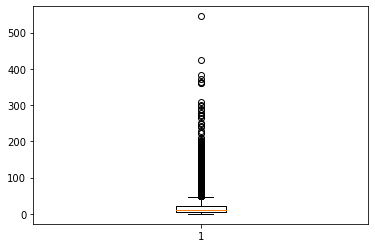

In [21]:
plt.boxplot(comments['count_words_body'])

In [22]:

rang = [1,5,10,15,20,30,40,50, 60,70, 80, 90, 100, 150, 200,250, 600] 
distr_reviews_tokens = pd.DataFrame(columns=['review size','reviews']) 
for k, n in enumerate(list(range(len(rang)-1))): 
    i=rang[n] 
    j = rang[n+1] 
    if  k == 0:
        s = comments[(comments['count_words_body'] >= i)&(comments['count_words_body'] <=j)]['count_words_body'].count()
        distr_reviews_tokens = distr_reviews_tokens.append({'review size': f'{i}-{j}','reviews':s},ignore_index=True) 
    else:
        s = comments[(comments['count_words_body'] > i)&(comments['count_words_body']  <=j)]['count_words_body'].count()
        distr_reviews_tokens = distr_reviews_tokens.append({'review size': f'{i+1}-{j}','reviews':s},ignore_index=True) 

In [23]:
distr_reviews_tokens

,review size,reviews
0,1-5,55876
1,6-10,46636
2,11-15,34575
3,16-20,27111
4,21-30,34589
5,31-40,16640
6,41-50,7911
7,51-60,4373
8,61-70,2465
9,71-80,1473


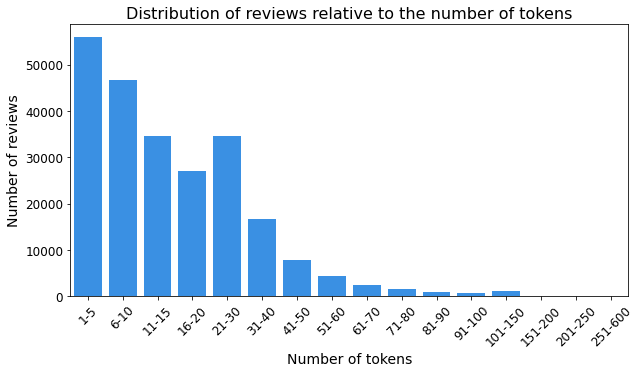

In [24]:

plt.figure(figsize=(10,5))
sns.barplot(x ='review size',y ='reviews',data = distr_reviews_tokens , color = 'dodgerblue')
plt.xlabel("Number of tokens",fontsize = 14)
plt.ylabel("Number of reviews",fontsize = 14)
plt.title("Distribution of reviews relative to the number of tokens", fontsize = 16) 
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


In [24]:
comments[comments['count_words_body']==545].body.values

array(['Купила я две краски для деревянных фасадов, компании V33 (база С сатиновая, 9 л. ведро) и сделала колировку двух цветов (S424 (на мой взгляд, этот цвет ежевичного йогурта, немного меняет цвет от времени суток) и N425 (а этот цвет или тёмно-пряная вишня или сливовый (когда слива вымыта от сизого налёта)). Приобретала я её в магазине LEROY MERLIN (Леруа Мерлен Восток Дом для Дома) в конце августа 2016 года. Красить ей начала так же в этом году, но только в сентябре. Почему не сразу начала красить??? Да потому что на ней написано, что можно красить до +25С и нельзя, чтобы был сквозняк (я так понимаю при сильном ветре нельзя красить). Вот и приняли решения с мужем, что красить начнём с начала сентября, а ещё лучше с середины, когда погода станет по прохладней, а то в этом году август был африканский, жарища ужасная, да иногда был порывистый ветер. Сам дом наш очень старый (1954 года), соответственно и шалёвка старая, во многих местах вся порепанная и имеются очень большие трещины, 

In [25]:
comments[comments['count_words_body']==0]

,id,product_external_id,body,pros,cons,rating,published_at,origin,price_rating,quality_rating,clean_body,clean_pros,clean_cons,count_words_body,count_words_pros,count_words_cons
570,60c8bf346eb1fb00229619a3,82198217,Их нет,НИКАКИХ,Течет сильно. Запах ужасный. Высохло...,1,2021-06-16 09:54:29.611000064,submissions_api,4.0,1.0,,никакой,течь сильно запах ужасный высыхать с...,0,1.0,6.0
651,59a51ce8c68326003c13b476,12151252,"То, что надо",None,None,5,2017-08-30 09:50:16.924000000,multi_reviews_form,NaN,NaN,,None,None,0,NaN,NaN
705,617e43cda6a091001b28096f,82800679,-,"наносит клей хорошо, брали для этих ...","не совсем удобно наносить, ручка шир...",4,2021-11-01 13:47:47.308000000,submissions_api,NaN,NaN,,наносить клей брать цель,удобный наносить ручка широковатый,0,4.0,4.0
1387,5ed23e17b94dba000f36fd6d,82113285,Нет,"Действительно не оставляет разводов,...",Нет,5,2020-05-31 15:53:37.623000064,submissions_api,NaN,NaN,,действительно оставлять разводы соед...,,0,9.0,0.0
1438,60561437922c92001816ed56,82891662,👍,👍,-------их нет,5,2021-03-21 13:44:03.417999872,omnibox,5.0,5.0,,,,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233856,5f3eaf668bd369000f8e5ee4,82622650,-,"Очень красивая люстра,особенно подош...",Для стандартной высоты потолка слишк...,5,2020-08-21 11:49:24.660000000,submissions_api,NaN,NaN,,очень красивый люстраособенно подход...,стандартный высота потолок слишком н...,0,9.0,9.0
233929,5aa6799c1204b3003c12f90e,14175469,все хорошо,хорошо смотрится,None,5,2018-03-14 12:44:38.150000128,submissions_api,NaN,NaN,,смотреться,None,0,1.0,NaN
234027,6024c6a27d378c0014a75a94,82063083,-,Красивый и стильный дизайн,"Сломался быстро, чуть больше года ис...",3,2021-02-12 17:12:34.704999936,submissions_api,NaN,NaN,,красивый стильный дизайн,сломаться быстро год исполняться нач...,0,3.0,8.0
235012,61b83382862d7a001c5bf14d,90145250,х,х,"Хотелось бы еще добавить, что диамет...",3,2021-12-15 18:58:29.278000128,submissions_api,3.0,4.0,,,хотеться добавлять диаметр около мет...,0,0.0,31.0


In [26]:
most_common_words_df = pd.Series(' '.join(comments['clean_body']).split()).value_counts().reset_index().rename({'index':'words', 0:'frequency'},axis='columns')


In [27]:
most_common_words_df [:50]

,words,frequency
0,очень,51086
1,хороший,30602
2,весь,29494
3,купить,28477
4,качество,23392
5,работать,21247
6,отличный,20796
7,цена,20722
8,год,19471
9,брать,18120


We see that there are reviews that do not contain  tokens.  But these reviews have pros and cons. Then we can take them into account as a review text. It's may be useful. 

We can also exclude reviews that contain too many tokens so that they do not level the rest.

In [28]:
comments = comments[comments['count_words_body']!=0]

In [29]:
comments = comments[comments['count_words_body']<=200]

In [30]:
comments = comments[comments['count_words_body']>=2]

In [31]:
comments.reset_index(drop = True, inplace = True)

## Distribution of reviews

In [32]:
comments = comments[(pd.notna(comments['body'] ))].reset_index(drop = True)

In [33]:
print( 'Total number of reviews: ', comments.shape[0])
print( 'Total number of product: ', comments.product_external_id.nunique())
print( 'Average number of product reviews: ', round(comments.shape[0]/ comments.product_external_id.nunique(),0))

Total number of reviews:  227172
Total number of product:  34072
Average number of product reviews:  7.0


In [34]:
print( 'Total number of reviews: ', comments.shape[0])
print( 'Total number of product: ', comments.product_external_id.nunique())
print( 'Average number of product reviews: ', round(comments.shape[0]/ comments.product_external_id.nunique(),0))

Total number of reviews:  227172
Total number of product:  34072
Average number of product reviews:  7.0


In [35]:
grp_sizes = comments.set_index('product_external_id').groupby('product_external_id')\
    .body.transform('size').to_frame(name='sizes').sizes.value_counts()
grp_sizes = grp_sizes.reset_index()
grp_sizes.columns = ['sizes','counts']

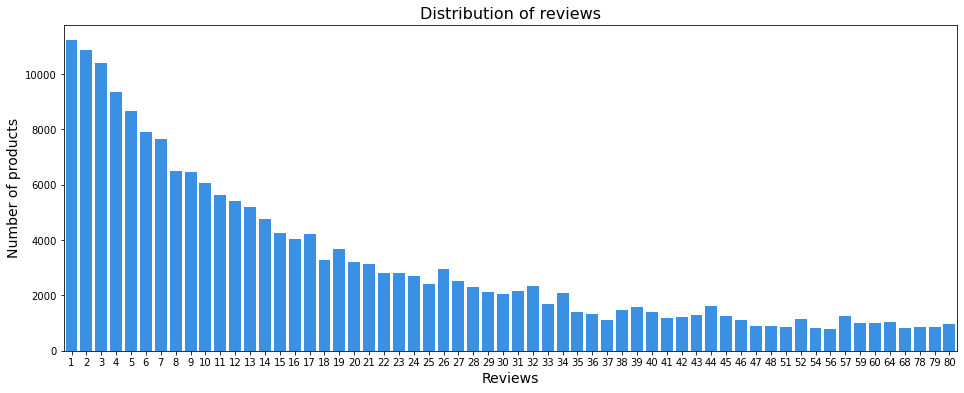

In [36]:
plt.figure(figsize=(16,6))
sns.barplot(x = "sizes", y = "counts", data = grp_sizes[:60], color = 'dodgerblue')
plt.xlabel("Reviews",fontsize = 14)
plt.ylabel("Number of products",fontsize = 14)
plt.title("Distribution of reviews",fontsize = 16) 
plt.show()

In this graph, we can see that there are a large number of products that have less than 10 reviews.
We can remove products with less than 8 reviews. For such products, it is not advisable to summarize the reviews.

In [37]:
item_supports = comments.groupby('product_external_id').size().to_frame(name='comment_size').reset_index()
item_supports = item_supports[item_supports['comment_size']>8]

In [38]:
comments_clean = comments.merge(item_supports, how='inner', on='product_external_id')

In [39]:
print( 'Total number of reviews: ', comments_clean.shape[0])
print( 'Total number of product: ', comments_clean.product_external_id.nunique())
print( 'Average number of product reviews: ', round(comments_clean.shape[0]/ comments_clean.product_external_id.nunique(),0))
print( 'Max number of product reviews: ', grp_sizes.sizes.max())

Total number of reviews:  154597
Total number of product:  6651
Average number of product reviews:  23.0
Max number of product reviews:  223


In [40]:

rang = [8,15,25,50,75,100,250] 
distr_points = pd.DataFrame(columns=['points size','points']) 
for k, n in enumerate(list(range(len(rang)-1))): 
    i=rang[n] 
    j = rang[n+1] 
    if  k == 0:
        s = item_supports[(item_supports['comment_size'] >= i)&(item_supports['comment_size'] <=j)]['comment_size'].count()
        distr_points = distr_points.append({'points size': f'{i}-{j}','points':s},ignore_index=True) 
    else:
        s = item_supports[(item_supports['comment_size'] > i)&(item_supports['comment_size'] <=j)]['comment_size'].count()
        distr_points = distr_points.append({'points size': f'{i+1}-{j}','points':s},ignore_index=True) 



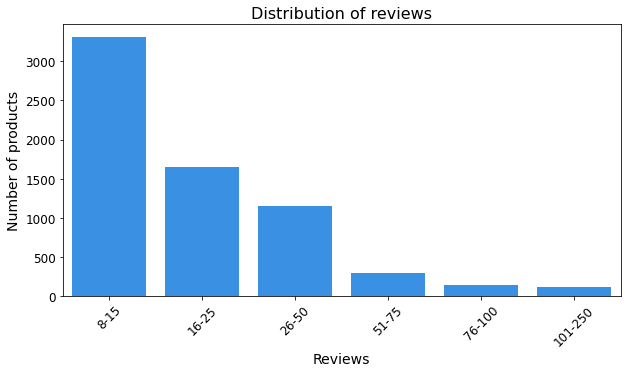

In [41]:

plt.figure(figsize=(10,5))
sns.barplot(x ='points size',y ='points',data = distr_points , color = 'dodgerblue')
plt.xlabel("Reviews",fontsize = 14)
plt.ylabel("Number of products",fontsize = 14)
plt.title("Distribution of reviews", fontsize = 16) 
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


### Example of summarization

In [42]:
import random
item_keep = random.choices(comments_clean.product_external_id.unique(), k = 50) 
comments_clean[comments_clean.product_external_id.isin(item_keep)].to_excel('human_summarize.xlsx', index = False)

In [47]:
product_rating = comments_clean[['product_external_id','rating']].groupby('product_external_id').agg({'rating':['mean', 'count']})

In [48]:
product_rating .columns = ["_".join(x) for x in product_rating .columns.ravel()]
product_rating .reset_index(inplace = True)

In [55]:
product_rating 

,product_external_id,rating_mean,rating_count
0,32539,3.538462,13
1,864315,3.952381,84
2,903566,3.800000,10
3,909017,4.222222,18
4,909035,4.307692,13
...,...,...,...
6646,98299545,5.000000,11
6647,98299546,5.000000,11
6648,98299547,5.000000,9
6649,98299548,5.000000,10


In [63]:
product_rating[product_rating['rating_mean']< 2.5].sort_values(by = 'rating_count', ascending = False)[90:100]

,product_external_id,rating_mean,rating_count
554,12902845,2.423077,26
6536,88740476,1.653846,26
36,10027258,2.192308,26
2414,18156062,2.307692,26
3304,31792866,2.269231,26
68,10252391,1.423077,26
4975,82263650,1.653846,26
3116,18775998,1.615385,26
3089,18749159,2.200000,25
1422,15287294,2.400000,25


## Analysis Rating Reviews

We have three type of rating reviews: 

* overall rating 
* price rating 
* quality rating

In this part of the analysis we look at: 
* How reviews are distributed in relation to the three types of rating and which of the two quality and price ratings gives more weight to the overall rating. 
* How rating change over time
* Top adjectives  relative to rating

We have some reviews without publish date 

In [64]:
comments_clean[comments_clean.month.isnull()].shape[0]

AttributeError: 'DataFrame' object has no attribute 'month'

In [ ]:
#Add some date
comments_clean = comments_clean[~comments_clean.month.isnull()]
comments_clean['date'] = comments_clean['published_at'].dt.date
comments_clean['year'] = comments_clean['published_at'].dt.year
comments_clean['month'] = comments_clean['published_at'].dt.month
comments_clean['year-month'] = comments_clean['year'].astype('str') +"-" +  \
                              comments_clean['month'].astype('int').apply(lambda x: "{:02d}".format(x))

In [ ]:
comments_clean.set_index('rating').groupby('id')\
    .id.transform('size').to_frame(name='sizes').sizes.value_counts()

1    154597
Name: sizes, dtype: int64

In [ ]:
rating_cnt = comments_clean.groupby('rating')['id'].count().to_frame(name='counts')
rating_cnt = rating_cnt.reset_index()
rating_cnt.columns = ['rating','counts']

rating_price_cnt = comments_clean.groupby('price_rating')['id'].count().to_frame(name='counts')
rating_price_cnt = rating_price_cnt.reset_index()
rating_price_cnt.columns = ['rating','counts_price_rating']

rating_quality_cnt = comments_clean.groupby('quality_rating')['id'].count().to_frame(name='counts')
rating_quality_cnt = rating_quality_cnt.reset_index()
rating_quality_cnt.columns = ['rating','counts_quality_rating']

In [ ]:
rating_cnt.merge(rating_price_cnt, on = 'rating', how = 'left').merge(rating_quality_cnt, on = 'rating', how = 'left')

,rating,counts,counts_price_rating,counts_quality_rating
0,1,29856,7682,14737
1,2,9471,4223,5946
2,3,11360,10659,6715
3,4,16104,12908,11021
4,5,87806,53151,48764


In [ ]:
ratings = comments_clean[(~comments_clean.price_rating.isnull())&(~comments_clean.quality_rating.isnull())][['rating', 'price_rating','quality_rating' ]].reset_index( drop = True)

In [ ]:
def corrPairs(df):
    corr = df.corr() 
    mask = np.zeros_like(corr, dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5, annot=True, cbar=False)


<AxesSubplot:>

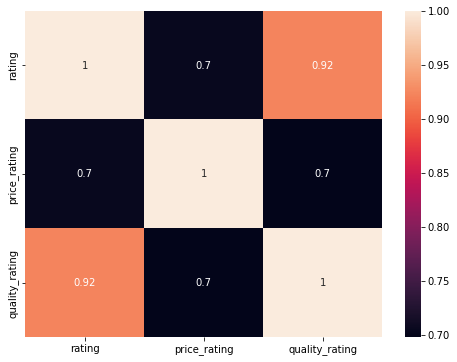

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(ratings.corr(),annot=True)

We see that the quality rating has a greater impact on the overall rating

In [228]:
r = comments_clean.groupby(['product_external_id','year'])['rating'].mean().reset_index()
rk = pd.pivot_table(r, values = 'rating', index='product_external_id', columns = 'year',aggfunc=np.sum, dropna= False)

In [309]:
rk[:10]

year,2016,2017,2018,2019,2020,2021,2022
product_external_id,,,,,,,
32539,NaN,NaN,NaN,NaN,NaN,3.538462,NaN
864315,NaN,NaN,4.0,4.500000,2.666667,4.233333,1.0
903566,NaN,NaN,NaN,4.000000,4.333333,3.400000,NaN
909017,NaN,NaN,NaN,NaN,4.750000,4.000000,3.5
909035,NaN,NaN,NaN,4.500000,3.666667,5.000000,NaN
909045,NaN,NaN,NaN,5.000000,4.818182,4.333333,4.0
909047,NaN,NaN,NaN,4.666667,5.000000,4.333333,NaN
914130,NaN,NaN,NaN,3.200000,3.419355,2.833333,4.0
914132,NaN,NaN,NaN,5.000000,3.857143,2.700000,3.0


In [299]:
#11467386, 11696728, 13115931, 13922864

In [ ]:
#POS-tagging 

In [69]:
k =' '.join(comments['clean_body'][:1])

In [70]:
document = nlp(k)

In [95]:

def get_adjs(text):
    adjs = []
    if text is not None:  
        document = nlp(text)
        for token in document:
            if token.pos_ == 'ADJ':
                adjs.append(token)
    else:
        return None
    return " ".join(str(x) for x in adjs)

In [96]:
comments['adjs_body'] = comments['clean_body'].swifter.apply(lambda x: get_adjs(x))

Pandas Apply:   0%|          | 0/227172 [00:00<?, ?it/s]

In [ ]:
comments['adjs_body'].swifter.apply(lambda x: get_adjs(x))

In [150]:
comments.to_csv('comments_clean.csv', index = False)

In [148]:
res = pd.DataFrame(columns=['rating','words', 'frequency']) 
rating_list = [1,2,3,4,5]
for i in rating_list:
    comments_rating = comments[(comments['rating']<=i)&(comments['rating']>i-1)]
    most_common_adjs_body_df = pd.Series(' '.join(comments_rating['adjs_body']).split()).value_counts().reset_index().rename({'index':'words', 0:'frequency'},axis='columns')
    most_common_adjs_body_df['rating'] = f'{i-1}-{i}'
    res = res.append(most_common_adjs_body_df)

In [149]:
res[res['rating'] =='0-1'][:30]


,rating,words,frequency
0,0-1,данный,3402
1,0-1,первый,2990
2,0-1,самый,1979
3,0-1,второй,1858
4,0-1,ужасный,1772
5,0-1,хороший,1700
6,0-1,плохой,1685
7,0-1,отвратительный,1659
8,0-1,новый,1489
9,0-1,полный,1210
